## Finetune to follow instruction

In [92]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.5
tiktoken version: 0.11.0
torch version: 2.8.0
tqdm version: 4.67.1
tensorflow version: 2.20.0


### 7.2 Preparing a dataset for supervised instruction finetuning

In [93]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [94]:
data[50]

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'"}

In [95]:
data[999]

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'."}

In [96]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [97]:
model_input = format_input(data[999])

print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?


In [98]:
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
The correct spelling is 'Occasion.'


In [99]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [100]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing Data into training batches 

In [101]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [102]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [103]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [24]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [104]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []
    target_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        target_lst.append(targets)
    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    target_tensor = torch.stack(target_lst).to(device)
    
    return inputs_tensor, target_tensor

In [105]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor, targets_tensor = custom_collate_draft_2(batch)

In [106]:
inputs_tensor

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

In [107]:
targets_tensor

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])

In [108]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [109]:
inputs_tensor, targets_tensor = custom_collate_fn(batch)

In [110]:
targets_tensor

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])

In [111]:
inputs_tensor

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

In [112]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [113]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [114]:
logits_3 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_3 = torch.tensor([0, 1, -100])

loss_2 = torch.nn.functional.cross_entropy(logits_3, targets_3)
print(loss_2)

tensor(1.1269)


In [39]:
## 7.4 Creating data loaders for an instruction dataset

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [117]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [118]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [119]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [120]:
inputs[0]

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])

In [121]:
targets[0]

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [122]:
len(inputs[0])

69

In [123]:
inputs[2]

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 33234,  1958,   262,  8718,  3281,    76,
          329,   262,  1573,   705, 13698,  2637,   198,   198, 21017, 18261,
           25,   198,   464,  8718,  3281,    76,   329,   262,  1573,   705,
        13698,     6,   318,   705, 25547,  2637, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])

In [124]:
targets[2]

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 33234,  1958,   262,  8718,  3281,    76,   329,
          262,  1573,   705, 13698,  2637,   198,   198, 21017, 18261,    25,
          198,   464,  8718,  3281,    76,   329,   262,  1573,   705, 13698,
            6,   318,   705, 25547,  2637, 50256,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [125]:
len(inputs[2])

69

In [53]:
## 7.5 Loading a Pre-trained LLM

In [128]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [129]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [130]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# Alternatively:
# from llms_from_scratch.ch05 import (
#    generate,
#    text_to_token_ids,
#    token_ids_to_text
# )


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [131]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [132]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


## 7.6 Finetuning the LLM on instruction Data

In [133]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [134]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.167110824584961
Validation loss: 4.0509062767028805


In [135]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.119, Val loss 3.069
Ep 1 (Step 000005): Train loss 1.697, Val loss 1.570
Ep 1 (Step 000010): Train loss 1.096, Val loss 1.164
Ep 1 (Step 000015): Train loss 1.053, Val loss 1.083
Ep 1 (Step 000020): Train loss 0.970, Val loss 1.038
Ep 1 (Step 000025): Train loss 0.920, Val loss 1.002
Ep 1 (Step 000030): Train loss 0.960, Val loss 0.978
Ep 1 (Step 000035): Train loss 0.877, Val loss 0.951
Ep 1 (Step 000040): Train loss 0.847, Val loss 0.943
Ep 1 (Step 000045): Train loss 0.777, Val loss 0.925
Ep 1 (Step 000050): Train loss 0.869, Val loss 0.911
Ep 1 (Step 000055): Train loss 0.923, Val loss 0.893
Ep 1 (Step 000060): Train loss 0.872, Val loss 0.878
Ep 1 (Step 000065): Train loss 0.800, Val loss 0.867
Ep 1 (Step 000070): Train loss 0.694, Val loss 0.860
Ep 1 (Step 000075): Train loss 0.706, Val loss 0.855
Ep 1 (Step 000080): Train loss 0.753, Val loss 0.847
Ep 1 (Step 000085): Train loss 0.680, Val loss 0.836
Ep 1 (Step 000090): Train loss 0.729, Val loss

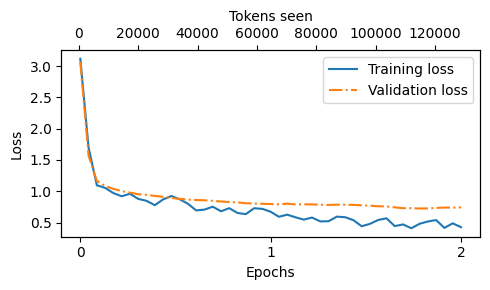

In [136]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 Extracting and Saving Responses 

In [138]:
torch.manual_seed(123)


for entry in test_data[:7]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 

In [139]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|████████████████████████████████████████████| 110/110 [01:11<00:00,  1.53it/s]


In [140]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a horse.'}


In [141]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-small124M-sft.pth


In [142]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [143]:
## Evaluation

In [144]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [145]:
import urllib.request

def query_model(
    prompt,
    model="llama3.2",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3.2"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and vitamins.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach, which allows them to break down and extract nutrients from plant material more efficiently than many other 

In [146]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    #print(prompt)
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.

Score:
>> To rewrite the sentence using a simile, we need to compare two things that are not alike, but share a common characteristic.

Correct output: The car is as fast as lightning.

Score: 0/100 (The model response "The car is as fast as a horse." uses a metaphor, which is different from a simile. A simile should use the words "like" or "as" to make the comparison.)

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.

Score:
>> I would rate the model response a 0 out of 100.

The reason for this low score is that the model's response completely deviates from the correct answer and provides an unrelated piece of information (tropical rainforest) instead of providing accurate information about cumulonimbus

In [ ]:
JUDGE_PROMPT = """
You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance.
You will be given an instruction, a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing the evaluation criteria.
Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
Please do not generate any other opening, closing, and explanations.

Here is the rubric you should use to build your answer:
1: The response fails to address the instructions, providing irrelevant, incorrect, or excessively verbose information that detracts from the user's request.
2: The response partially addresses the instructions but includes significant inaccuracies, irrelevant details, or excessive elaboration that detracts from the main task.
3: The response follows the instructions with some minor inaccuracies or omissions. It is generally relevant and clear, but may include some unnecessary details or could be more concise.
4: The response adheres to the instructions, offering clear, accurate, and relevant information in a concise manner, with only occasional, minor instances of excessive detail or slight lack of clarity.
5: The response fully adheres to the instructions, providing a clear, accurate, and relevant answer in a concise and efficient manner. It addresses all aspects of the request without unnecessary details or elaboration

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the instruction, the reference answer, and the response.

Instruction: {instruction}
Reference Answer: {reference}
Answer: {answer}


Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """

In [147]:
def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  10%|██▊                         | 11/110 [00:02<00:29,  3.37it/s]

Could not convert score: 20

Explanation: The correct classification of the input numbers is:
Prime numbers: 11, 19
Composite numbers: 14

The model response contains errors in both classification and terminology. It incorrectly labels 14 as a prime number and uses the incorrect term "prime composite numbers".


Scoring entries:  15%|████▎                       | 17/110 [00:04<00:28,  3.23it/s]

Could not convert score: I would classify Mercury as a liquid because it's a metal that can flow and has a high density. Oxygen is a gas because it's an element that can expand and fill its container. Wood is a solid because it's a rigid material that doesn't change shape or volume when heated.

Score: 100


Scoring entries:  17%|████▊                       | 19/110 [00:04<00:23,  3.95it/s]

Could not convert score: 60

A note was left by someone.


Scoring entries:  30%|████████▍                   | 33/110 [00:06<00:14,  5.40it/s]

Could not convert score: 80

It's very easy.


Scoring entries:  46%|████████████▉               | 51/110 [00:10<00:11,  5.24it/s]

Could not convert score: 80

The synonym for the given verb is 'commence'.


Scoring entries:  49%|█████████████▋              | 54/110 [00:10<00:12,  4.52it/s]

Could not convert score: 50

The corrected output should be:

Vehicles: Bicycle
Plants: Rose
Animals: Tiger


Scoring entries:  55%|███████████████▌            | 61/110 [00:12<00:09,  5.20it/s]

Could not convert score: 90

The sentence "Chocolate is the best dessert" is opinion-based.


Scoring entries:  62%|█████████████████▎          | 68/110 [00:13<00:08,  4.77it/s]

Could not convert score: The rewritten sentence as a question is: "Did the dog chase the cat?"

Score: 0


Scoring entries:  65%|██████████████████▎         | 72/110 [00:14<00:08,  4.72it/s]

Could not convert score: The corrected sentence is: I prefer homemade cookies to store bought.

Score: 0


Scoring entries:  67%|██████████████████▊         | 74/110 [00:14<00:09,  3.92it/s]

Could not convert score: 90

This manual provides instructions for installing the software. Technical documents are technical documents that describe a task.


Scoring entries:  69%|███████████████████▎        | 76/110 [00:16<00:16,  2.11it/s]

Could not convert score: I would give the model response a score of 80.

Here's why:

- The model correctly identifies that the list needs to be sorted in descending order.
- It provides the correct sorted list: `25, 16, 10, 7, 2`.
- However, it does not explicitly state "in descending order" after providing the sorted list. This is a minor point, but still an important aspect of clarity.

Overall, the model response is clear and accurate, which is why I would give it a high score.


Scoring entries:  77%|█████████████████████▋      | 85/110 [00:17<00:04,  5.22it/s]

Could not convert score: 60

He remained very calm.


Scoring entries:  80%|██████████████████████▍     | 88/110 [00:19<00:06,  3.30it/s]

Could not convert score: 60

The corrected sentence "My friend and I went to the store." is grammatically correct, but it doesn't make sense in the context of the original instruction. The model response "The store was very crowded." is a separate statement that is not related to correcting the original sentence.


Scoring entries:  99%|██████████████████████████▊| 109/110 [00:22<00:00,  4.93it/s]

Could not convert score: 90

The classification of the sentence 'Please open the door.' is imperative.


Scoring entries: 100%|███████████████████████████| 110/110 [00:22<00:00,  4.80it/s]

Number of scores: 96 of 110
Average score: 35.10



In [149]:
len(scores)

96

In [150]:
#!pip install "gradio>=4.0.0"

In [151]:
#! pip install "huggingface_hub>=0.15.1"

In [152]:
scores

[20,
 0,
 0,
 20,
 80,
 60,
 80,
 0,
 0,
 90,
 80,
 20,
 60,
 0,
 30,
 20,
 60,
 20,
 90,
 0,
 60,
 0,
 60,
 0,
 20,
 80,
 60,
 0,
 20,
 20,
 80,
 20,
 90,
 0,
 20,
 0,
 80,
 20,
 20,
 0,
 20,
 60,
 60,
 90,
 80,
 60,
 60,
 0,
 50,
 60,
 90,
 80,
 20,
 90,
 20,
 20,
 20,
 20,
 0,
 60,
 20,
 20,
 20,
 20,
 0,
 20,
 50,
 30,
 20,
 90,
 20,
 20,
 0,
 0,
 0,
 0,
 0,
 20,
 20,
 60,
 0,
 60,
 50,
 60,
 80,
 20,
 80,
 80,
 20,
 20,
 50,
 20,
 20,
 20,
 20,
 0]